# 04 — Final Report: E-Commerce Funnel Optimization

**Objective:** Translate analysis outputs into a stakeholder-ready report highlighting funnel drop-off, customer value, and high-ROI actions.

**Dataset:** UCI Online Retail (2010–2011)

**This notebook depends on outputs produced by:**
- `02_data_cleaning.ipynb`
- `03_funnel_analysis.ipynb`

## Executive Summary

This report summarizes results from a one-year transaction dataset from a UK-based online retailer.

We focus on:
- **Retention funnel:** Active → Engaged → Repeat → High-Value customers  
- **Customer value concentration:** how revenue is distributed across customers  
- **RFM segmentation:** Champions / Loyal / At Risk, etc. and revenue contribution  
- **Product performance:** top products and revenue concentration  
- **Returns:** scale + operational signals

**Main takeaway:** The biggest ROI lever is usually improving **second purchase** and **repeat behavior**, then targeting retention by segment.

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Pretty tables in notebook
pd.set_option("display.max_columns", None)

# ---------- Paths ----------
PROCESSED = Path("../data/processed")

files = {
    "cleaned":  PROCESSED / "cleaned_purchases.csv",
    "returns":  PROCESSED / "returns.csv",
    "customers": PROCESSED / "customer_metrics.csv",
    "products":  PROCESSED / "product_performance.csv",
    "rfm":      PROCESSED / "rfm_analysis.csv",
}

missing = [k for k, p in files.items() if not p.exists()]
if missing:
    raise FileNotFoundError(
        f"Missing required outputs: {missing}\n"
        f"Expected them in: {PROCESSED.resolve()}\n"
        f"Run notebooks 02 and 03 first."
    )

# ---------- Load ----------
cleaned  = pd.read_csv(files["cleaned"])
returns  = pd.read_csv(files["returns"])
customers = pd.read_csv(files["customers"])
products  = pd.read_csv(files["products"])
rfm       = pd.read_csv(files["rfm"])

# ---------- Standardize small mismatches ----------
# If products has Orders instead of NumOrders, normalize to NumOrders
if "Orders" in products.columns and "NumOrders" not in products.columns:
    products = products.rename(columns={"Orders": "NumOrders"})

# Convert dates if present (safe)
for col in ["InvoiceDate", "FirstPurchase", "LastPurchase"]:
    for df in [cleaned, returns, customers]:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors="coerce")

print("✅ Loaded files:")
print(f"cleaned:   {cleaned.shape}")
print(f"returns:   {returns.shape}")
print(f"customers: {customers.shape}")
print(f"products:  {products.shape}")
print(f"rfm:       {rfm.shape}")

✅ Loaded files:
cleaned:   (392119, 15)
returns:   (8905, 9)
customers: (4277, 8)
products:  (3889, 5)
rfm:       (4277, 9)


In [2]:
expected_cols = {
    "customers": {"CustomerID","NumOrders","TotalSpent","FirstPurchase","LastPurchase","MonthsActive","DaysSinceFirst","CustomerSegment"},
    "products":  {"StockCode","Description","TotalQuantity","Revenue","NumOrders"},
    "rfm":       {"CustomerID","Recency","Frequency","Monetary","R_Score","F_Score","M_Score","RFM_Total","Segment"},
}

def missing_cols(df, wanted):
    return sorted(list(wanted - set(df.columns)))

print("🔎 Missing columns check:")
print("customers:", missing_cols(customers, expected_cols["customers"]))
print("products: ", missing_cols(products, expected_cols["products"]))
print("rfm:      ", missing_cols(rfm, expected_cols["rfm"]))

display(customers.head())
display(rfm.head())
display(products.head())

🔎 Missing columns check:
customers: []
products:  []
rfm:       []


,CustomerID,NumOrders,TotalSpent,FirstPurchase,LastPurchase,MonthsActive,DaysSinceFirst,CustomerSegment
0,12347.0,7,4060.40,2010-12-07 14:57:00,2011-12-07 15:52:00,7,365,International
1,12348.0,4,1306.68,2010-12-16 19:09:00,2011-09-25 13:13:00,4,282,International
2,12349.0,1,1457.55,2011-11-21 09:51:00,2011-11-21 09:51:00,1,0,International
3,12350.0,1,334.40,2011-02-02 16:01:00,2011-02-02 16:01:00,1,0,International
4,12352.0,8,1849.49,2011-02-16 12:33:00,2011-11-03 14:37:00,4,260,International


,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Total,Segment
0,12347.0,2,7,4060.40,5,5,5,15,Champions
1,12348.0,75,4,1306.68,2,4,4,10,Big Spenders
2,12349.0,19,1,1457.55,4,1,4,9,Promising
3,12350.0,310,1,334.40,1,1,2,4,At Risk
4,12352.0,36,8,1849.49,3,5,4,12,Big Spenders


,StockCode,Description,TotalQuantity,Revenue,NumOrders
0,10002,INFLATABLE POLITICAL GLOBE,823,699.55,49
1,10080,GROOVY CACTUS INFLATABLE,291,114.41,21
2,10120,DOGGY RUBBER,193,40.53,29
3,10123C,HEARTS WRAPPING TAPE,5,3.25,3
4,10124A,SPOTS ON RED BOOKCOVER TAPE,16,6.72,5


## Data Context & Cleaning Summary

The original dataset contains ~541k transaction rows. Cleaning was required to support customer-level analysis:

- Removed rows missing `CustomerID` (~25%)
- Separated returns/cancellations (~2%)
- Removed outliers/invalid records
- Produced clean purchases table used for downstream analysis

In [3]:
raw_reference = 541_909  # published raw row count for this dataset
remaining = len(cleaned) + len(returns)
removed_est = raw_reference - remaining
returns_rate = len(returns) / remaining * 100

print("=== Cleaning Summary (computed from saved outputs) ===")
print(f"Clean purchase rows: {len(cleaned):,}")
print(f"Return rows:         {len(returns):,}")
print(f"Total remaining:     {remaining:,}")
print(f"Approx removed vs raw {raw_reference:,}: {removed_est:,} rows")
print(f"Returns rate (approx): {returns_rate:.2f}%")

=== Cleaning Summary (computed from saved outputs) ===
Clean purchase rows: 392,119
Return rows:         8,905
Total remaining:     401,024
Approx removed vs raw 541,909: 140,885 rows
Returns rate (approx): 2.22%


## Customer Funnel Results

Because this is transactional data (not web events), we define a **retention funnel** based on purchase behavior:

1. **Active Customers:** customers with ≥ 1 order  
2. **Engaged Customers:** customers with ≥ 2 orders  
3. **Repeat Customers:** customers active in ≥ 2 distinct months  
4. **High-Value Customers:** top 20% by total spend

,Stage,Count,ConversionRate_%,DropOff,DropOffRate_%
0,Active Customers,4277,100.00,0.0,0.00
1,Engaged (2+ Orders),2796,65.37,1481.0,34.63
2,Repeat (2+ Months),2664,62.29,132.0,4.72
3,High-Value (Top 20% spend),856,20.01,1808.0,67.87


High-value threshold (Top 20% spend): £1,903.87


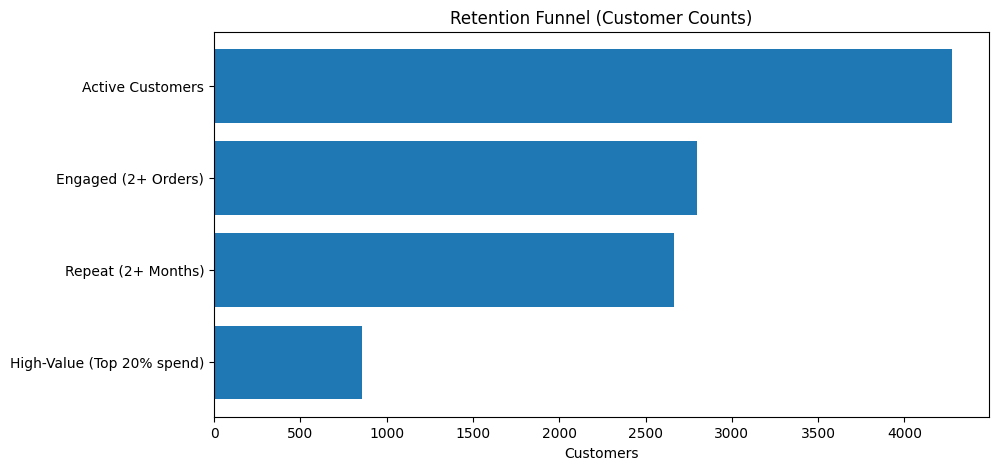

📌 Biggest drop-off: High-Value (Top 20% spend) (drop: 1808 customers)


In [4]:
active = customers["CustomerID"].nunique()
engaged = (customers["NumOrders"] >= 2).sum()
repeat = (customers["MonthsActive"] >= 2).sum()

high_value_threshold = customers["TotalSpent"].quantile(0.80)
high_value = (customers["TotalSpent"] >= high_value_threshold).sum()

stages = [
    ("Active Customers", active),
    ("Engaged (2+ Orders)", engaged),
    ("Repeat (2+ Months)", repeat),
    ("High-Value (Top 20% spend)", high_value),
]

funnel = pd.DataFrame(stages, columns=["Stage", "Count"])
funnel["ConversionRate_%"] = (funnel["Count"] / funnel.loc[0, "Count"] * 100).round(2)
funnel["DropOff"] = funnel["Count"].shift(1) - funnel["Count"]
funnel.loc[0, "DropOff"] = 0
funnel["DropOffRate_%"] = (funnel["DropOff"] / funnel["Count"].shift(1) * 100).round(2)
funnel.loc[0, "DropOffRate_%"] = 0.0

display(funnel)
print(f"High-value threshold (Top 20% spend): £{high_value_threshold:,.2f}")

plt.figure(figsize=(10,5))
plt.barh(funnel["Stage"], funnel["Count"])
plt.gca().invert_yaxis()
plt.title("Retention Funnel (Customer Counts)")
plt.xlabel("Customers")
plt.show()

biggest_drop = funnel.sort_values("DropOff", ascending=False).iloc[0]
print(f"📌 Biggest drop-off: {biggest_drop['Stage']} (drop: {int(biggest_drop['DropOff'])} customers)")

### Funnel Interpretation

Typically, the strongest ROI comes from increasing **second purchase** and **repeat purchasing**, because it grows revenue without requiring new customer acquisition.

## UK vs International Comparison

We compare customer behavior by segment (if available in `customer_metrics.csv`).

,Customers,AvgOrders,AvgMonths,AvgSpend,MedianSpend,TotalRevenue
CustomerSegment,,,,,,
UK,3861,4.16,2.99,1407.57,616.26,5434615.05
International,416,4.39,3.01,2670.56,981.88,1110951.85


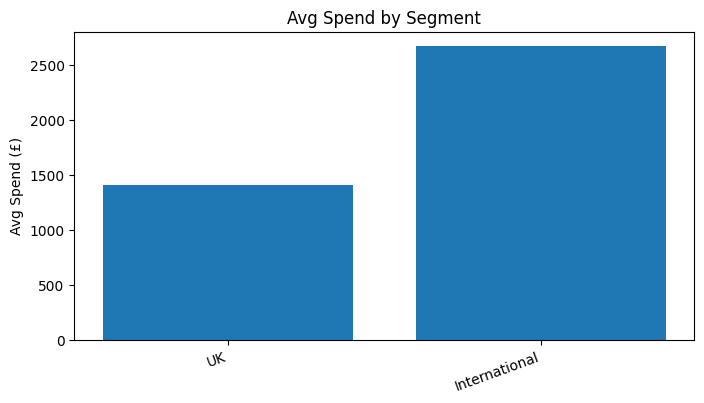

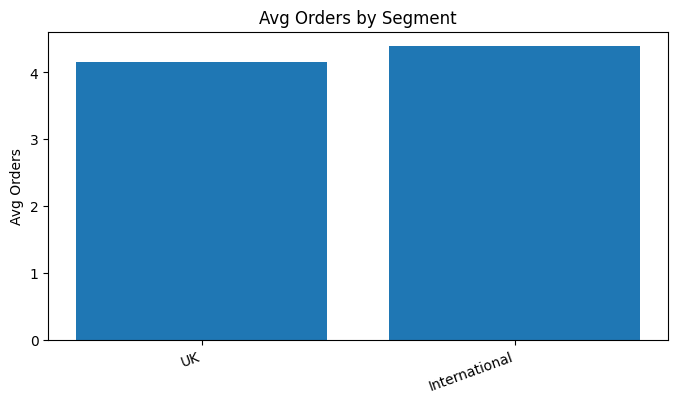

In [5]:
if "CustomerSegment" in customers.columns:
    seg = customers.groupby("CustomerSegment").agg(
        Customers=("CustomerID","nunique"),
        AvgOrders=("NumOrders","mean"),
        AvgMonths=("MonthsActive","mean"),
        AvgSpend=("TotalSpent","mean"),
        MedianSpend=("TotalSpent","median"),
        TotalRevenue=("TotalSpent","sum"),
    ).round(2).sort_values("TotalRevenue", ascending=False)

    display(seg)

    plt.figure(figsize=(8,4))
    plt.bar(seg.index.astype(str), seg["AvgSpend"])
    plt.title("Avg Spend by Segment")
    plt.ylabel("Avg Spend (£)")
    plt.xticks(rotation=20, ha="right")
    plt.show()

    plt.figure(figsize=(8,4))
    plt.bar(seg.index.astype(str), seg["AvgOrders"])
    plt.title("Avg Orders by Segment")
    plt.ylabel("Avg Orders")
    plt.xticks(rotation=20, ha="right")
    plt.show()
else:
    print("CustomerSegment not found in customers output — skipping segment comparison.")

## Customer Value Concentration

Most marketplaces show a skewed spend distribution: a minority of customers contribute a large share of revenue.

We quantify:
- Spend distribution shape
- Revenue share contributed by top 10% and top 1% customers

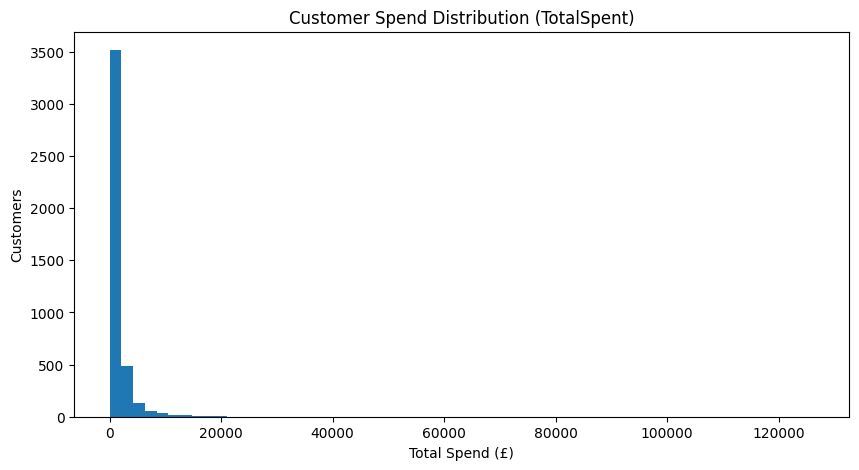

=== Revenue Concentration ===
Total revenue (customer spend): £6,545,566.90
Top 10% customers revenue share: 51.8%
Top 1% customers revenue share:  19.2%


count      4277.000000
mean       1530.410780
std        4108.020739
min           2.900000
25%         291.050000
50%         642.410000
75%        1545.620000
max      126386.360000
Name: TotalSpent, dtype: float64

In [6]:
x = customers["TotalSpent"].dropna()

plt.figure(figsize=(10,5))
plt.hist(x, bins=60)
plt.title("Customer Spend Distribution (TotalSpent)")
plt.xlabel("Total Spend (£)")
plt.ylabel("Customers")
plt.show()

rev_total = x.sum()
top_10_cut = x.quantile(0.90)
top_1_cut  = x.quantile(0.99)

rev_top10 = x[x >= top_10_cut].sum()
rev_top1  = x[x >= top_1_cut].sum()

print("=== Revenue Concentration ===")
print(f"Total revenue (customer spend): £{rev_total:,.2f}")
print(f"Top 10% customers revenue share: {rev_top10 / rev_total * 100:.1f}%")
print(f"Top 1% customers revenue share:  {rev_top1  / rev_total * 100:.1f}%")

display(x.describe())

## RFM Segmentation (Recency, Frequency, Monetary)

RFM groups customers based on:
- **Recency**: how recently they purchased (lower is better)
- **Frequency**: how often they purchase
- **Monetary**: how much they spend

This enables targeted strategies (protect Champions, win back At Risk, etc.).

,Customers,AvgRecency,AvgFrequency,AvgMonetary,TotalRevenue
Segment,,,,,
At Risk,1541,199.25,1.58,460.61,709800.82
Champions,959,13.11,10.70,4321.21,4144043.57
Need Attention,598,52.26,1.87,573.78,343120.28
Loyal,475,15.84,2.88,690.49,327982.19
Big Spenders,391,80.29,5.96,2274.75,889426.21
Promising,313,18.75,1.24,419.15,131193.83


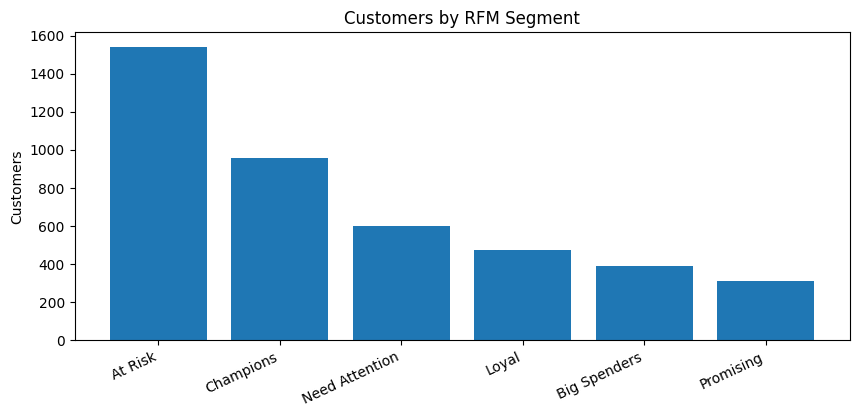

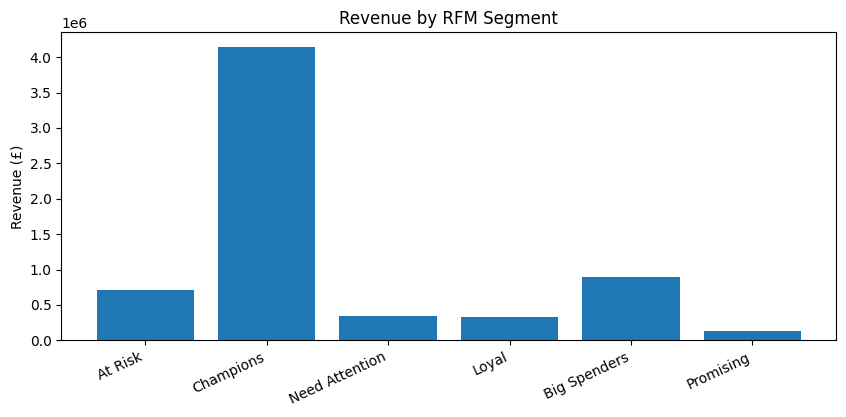

=== Revenue Share by Segment (%) ===


Segment
Champions         63.31
Big Spenders      13.59
At Risk           10.84
Need Attention     5.24
Loyal              5.01
Promising          2.00
Name: TotalRevenue, dtype: float64

In [7]:
segment_summary = rfm.groupby("Segment").agg(
    Customers=("CustomerID","count"),
    AvgRecency=("Recency","mean"),
    AvgFrequency=("Frequency","mean"),
    AvgMonetary=("Monetary","mean"),
    TotalRevenue=("Monetary","sum"),
).round(2).sort_values("Customers", ascending=False)

display(segment_summary)

plt.figure(figsize=(10,4))
plt.bar(segment_summary.index.astype(str), segment_summary["Customers"])
plt.title("Customers by RFM Segment")
plt.ylabel("Customers")
plt.xticks(rotation=25, ha="right")
plt.show()

plt.figure(figsize=(10,4))
plt.bar(segment_summary.index.astype(str), segment_summary["TotalRevenue"])
plt.title("Revenue by RFM Segment")
plt.ylabel("Revenue (£)")
plt.xticks(rotation=25, ha="right")
plt.show()

rev_total = segment_summary["TotalRevenue"].sum()
rev_share = (segment_summary["TotalRevenue"] / rev_total * 100).sort_values(ascending=False).round(2)

print("=== Revenue Share by Segment (%) ===")
display(rev_share)

## Product Performance

We analyze product revenue contribution to understand:
- which products drive the most revenue
- how concentrated revenue is in top products

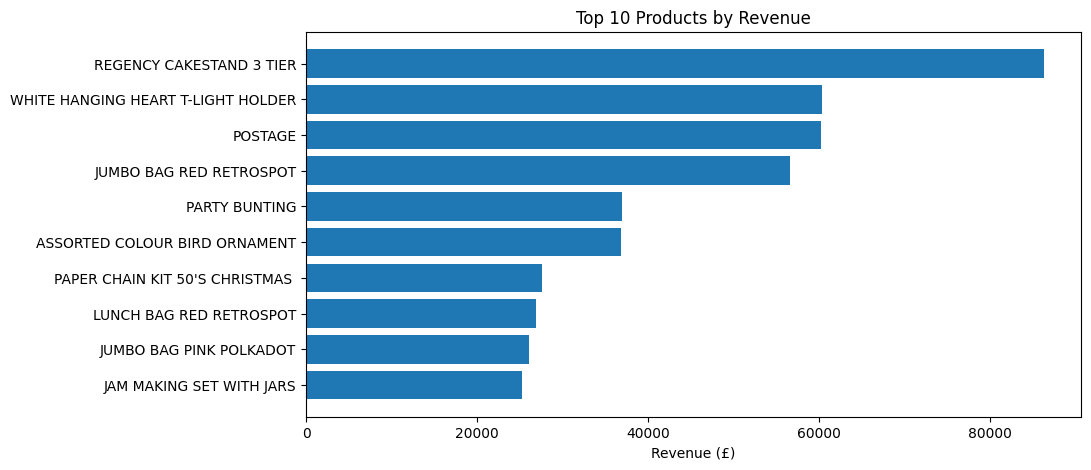

Top 10 products revenue share: 6.8%


In [8]:
topn = 10
top_products = products.sort_values("Revenue", ascending=False).head(topn)

plt.figure(figsize=(10,5))
plt.barh(top_products["Description"].astype(str), top_products["Revenue"])
plt.gca().invert_yaxis()
plt.title("Top 10 Products by Revenue")
plt.xlabel("Revenue (£)")
plt.show()

total_product_rev = products["Revenue"].sum()
top10_rev = top_products["Revenue"].sum()
print(f"Top 10 products revenue share: {top10_rev / total_product_rev * 100:.1f}%")

## Returns Overview

Returns/cancellations represent operational and customer experience signals.

We evaluate:
- approximate return transaction rate
- where returns are most common (country/product if available)

In [9]:
returns_rate = len(returns) / (len(returns) + len(cleaned)) * 100
print(f"Return transaction rate (approx): {returns_rate:.2f}%")

if "Country" in returns.columns:
    print("\nTop return countries:")
    display(returns["Country"].value_counts().head(10))

if "Description" in returns.columns:
    print("\nTop returned products:")
    display(returns["Description"].value_counts().head(10))

Return transaction rate (approx): 2.22%

Top return countries:


Country
United Kingdom    7533
Germany            453
EIRE               247
France             149
USA                112
Australia           74
Spain               48
Italy               45
Belgium             38
Japan               37
Name: count, dtype: int64


Top returned products:


Description
REGENCY CAKESTAND 3 TIER              181
Manual                                175
POSTAGE                                97
JAM MAKING SET WITH JARS               86
Discount                               77
SET OF 3 CAKE TINS PANTRY DESIGN       73
STRAWBERRY CERAMIC TRINKET BOX         55
ROSES REGENCY TEACUP AND SAUCER        53
RECIPE BOX PANTRY YELLOW DESIGN        47
WOOD 2 DRAWER CABINET WHITE FINISH     45
Name: count, dtype: int64

## Business Recommendations

1) **Increase second-purchase conversion (retention)**
- Trigger post-purchase follow-ups within 7–14 days
- Add loyalty incentives (points, discounts, free shipping thresholds)

2) **Segment marketing by RFM**
- **Champions/Loyal:** VIP perks, personalization, early access
- **At Risk:** win-back campaigns with time-limited offers
- Reduce broad campaigns to avoid wasted spend

3) **Manage product revenue concentration**
- Ensure best-sellers have strong inventory + merchandising
- Bundle best-sellers with mid-tier products to diversify revenue

4) **Use returns as a quality signal**
- Monitor high-return SKUs for packaging/description/quality improvements
- Flag international return patterns as potential shipping/expectation gaps

## Limitations & Next Steps

**Limitations**
- Transaction data does not contain true web funnel events (views/cart/checkout)
- Transactions without CustomerID were removed, so anonymous behavior is excluded

**Next Steps**
- Add cohort retention analysis (monthly cohorts)
- Add deeper country-level retention comparisons (UK vs International)
- If event-level data becomes available, rebuild a true web funnel

## Conclusion

This project demonstrates a reproducible pipeline:

**Exploration → Cleaning → Analysis Outputs → Final Reporting**

The results highlight retention as the primary lever: improving second purchase rate and targeting RFM segments can significantly improve revenue efficiency.